# 🤖 Machine Learning: Clasificación 

### 🎯 Objetivos del Proyecto:

1. **Desarrollar un modelo predictivo** confiable para clasificar pacientes con/sin Alzheimer
2. **Identificar las características más importantes** que contribuyen al diagnóstico
3. **Optimizar el rendimiento** mediante búsqueda de hiperparámetros
4. **Evaluar la calidad del modelo** usando métricas médicas relevantes
5. **Proporcionar interpretabilidad** para uso clínico

### 🌳 ¿Por qué Random Forest para Alzheimer?

**Random Forest** es especialmente adecuado para diagnóstico médico porque:

#### ✅ **Ventajas:**
- **Robusto a outliers**: Común en datos médicos
- **Maneja datos mixtos**: Numéricas y categóricas simultáneamente
- **Proporciona importancia de características**: Crucial para interpretación médica
- **Reduce overfitting**: Combina múltiples árboles de decisión
- **No requiere normalización**: Simplifica el preprocesamiento
- **Maneja datos faltantes**: Frecuente en registros médicos


### 📊 Contexto del Problema:

- **Tipo**: Clasificación binaria (Alzheimer: Sí/No)
- **Variables**: Demográficas, estilo de vida, medidas clínicas, síntomas
- **Objetivo médico**: Apoyo al diagnóstico temprano
- **Impacto**: Detección precoz puede mejorar calidad de vida del paciente

## 📚 1. Importación de Librerías Especializadas

Importamos un conjunto completo de herramientas para machine learning médico:

- **Sklearn**: Librería principal para ML (modelos, métricas, validación)
- **GridSearchCV**: Para optimización automática de hiperparámetros
- **Pipeline**: Para crear flujos de trabajo reproducibles
- **SelectKBest**: Para selección automática de características
- **Joblib**: Para guardar modelos entrenados

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib

## 🔧 2. Preparación de Datos para Machine Learning

### Eliminación de Variables No Predictivas

**¿Por qué eliminamos estas columnas?**

- **PatientID**: Identificador único sin valor predictivo (causaría overfitting)
- **DoctorInCharge**: Variable administrativa irrelevante para el diagnóstico

### Separación de Variables

**X (Features/Características)**: Variables independientes que usaremos para predecir
**y (Target/Objetivo)**: Variable dependiente que queremos predecir (Diagnosis)

Esta separación es **fundamental** en ML para evitar "data leakage" (filtración de información del objetivo hacia las características).

In [2]:
# Load the dataset
data = pd.read_csv('../Data/alzheimers_disease_data.csv')

# Display the first 5 rows of the dataset
data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [3]:
# Eliminar columnas innecesarias
data = data.drop(['PatientID', 'DoctorInCharge'], axis=1)

# Separar características y variable objetivo
x = data.drop("Diagnosis", axis=1)
y = data["Diagnosis"]

### 🎯 División de Datos: Train/Test Split

**¿Por qué dividir los datos?**

La división **80% entrenamiento / 20% prueba** es una práctica estándar que nos permite:

#### 📚 **Conjunto de Entrenamiento (80%)**:
- **Entrenar** el modelo y ajustar parámetros
- **Aprender patrones** de los datos
- **Optimizar** hiperparámetros mediante validación cruzada

#### 🧪 **Conjunto de Prueba (20%)**:
- **Evaluar rendimiento real** en datos no vistos
- **Estimar generalización** del modelo
- **Simular rendimiento** en pacientes futuros

In [4]:
# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

## 🔧 3. Construcción del Pipeline de ML

### ¿Qué es un Pipeline?

Un **Pipeline** encapsula múltiples pasos de procesamiento en un objeto único, asegurando:
- **Reproducibilidad** del proceso completo
- **Prevención de data leakage** entre etapas
- **Facilita la validación cruzada** y optimización

### Componentes de nuestro Pipeline:

#### 🎯 **SelectKBest (Selector de Características)**:
- **Propósito**: Selecciona las K características más relevantes
- **Método**: f_classif (ANOVA F-test) para problemas de clasificación
- **Beneficio**: Reduce dimensionalidad y ruido, mejora interpretabilidad

#### 🌳 **RandomForestClassifier**:
- **class_weight='balanced'**: Compensa desbalance de clases automáticamente
- **random_state=42**: Garantiza reproducibilidad

### 🏥 Ventajas en Medicina:
- **Selección automática**: Identifica biomarcadores más relevantes
- **Reducción de ruido**: Elimina variables irrelevantes que podrían confundir el diagnóstico
- **Balance de clases**: Crítico cuando una condición es rara (como Alzheimer temprano)

In [5]:
# Definir el pipeline para la selección de características y el modelo
pipeline = Pipeline([
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])

### 🎛️ Definición del Espacio de Hiperparámetros

La **búsqueda de hiperparámetros** es crucial para obtener el mejor rendimiento del modelo.

#### 📊 **Parámetros del Selector (SelectKBest)**:
- **k=[10, 15, 20]**: Número de características a seleccionar
  - **Menor K**: Modelo más simple, menos ruido
  - **Mayor K**: Más información, posible ruido adicional

#### 🌲 **Parámetros del Random Forest**:

**n_estimators=[200, 300, 500]**: Número de árboles
- **Más árboles**: Mayor estabilidad y precisión
- **Menos árboles**: Entrenamiento más rápido

**max_depth=[10, 15, 20]**: Profundidad máxima de árboles
- **Mayor profundidad**: Puede capturar patrones complejos (riesgo de overfitting)
- **Menor profundidad**: Modelo más generalizable

**min_samples_split=[5, 10]**: Mínimo de muestras para dividir un nodo
- **Valores altos**: Previene overfitting, modelos más generales

**min_samples_leaf=[2, 4]**: Mínimo de muestras en cada hoja
- **Valores altos**: Reducen overfitting, mejoran generalización

### 🏥 Importancia en Medicina:
Optimizar hiperparámetros es crítico porque queremos **máxima precisión diagnóstica** minimizando **falsos positivos y negativos** que podrían afectar tratamientos.

In [6]:
param_grid = {
    'selector__k': [10, 15, 20],  # Probar distintos números de características
    'classifier__n_estimators': [200, 300, 500],  # Más árboles para estabilidad
    'classifier__max_depth': [10, 15, 20],  # Limitar profundidad para evitar sobreajuste
    'classifier__min_samples_split': [5, 10],  # Evitar divisiones demasiado específicas
    'classifier__min_samples_leaf': [2, 4],  # Evitar hojas con muy pocos datos
    'classifier__class_weight': [None, 'balanced']  # Ajustar peso de clases
}

In [7]:
# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(x_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__class_weight': [None, 'balanced'], 'classifier__max_depth': [10, 15, ...], 'classifier__min_samples_leaf': [2, 4], 'classifier__min_samples_split': [5, 10], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,score_func,<function f_c...001375428DA80>


In [8]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

## 📈 4. Evaluación del Modelo

### 🧪 Métricas de Evaluación Médica

En diagnóstico médico, diferentes métricas tienen implicaciones clínicas específicas:

#### 📊 **Classification Report** incluye:

**Precision (Precisión)**: 
- **TP / (TP + FP)** - De todos los diagnosticados con Alzheimer, ¿cuántos realmente lo tienen?
- **Alta precisión**: Pocos falsos positivos (evita tratamientos innecesarios)

**Recall (Sensibilidad)**:
- **TP / (TP + FN)** - De todos los que tienen Alzheimer, ¿cuántos detectamos?
- **Alto recall**: Pocos falsos negativos (no perdemos casos reales)

**F1-Score**:
- **Media armónica** de precisión y recall
- **Balance óptimo** entre ambas métricas

**Support**:
- **Número de casos reales** de cada clase en el conjunto de prueba

### 🎯 **Matriz de Confusión**:

Visualización clara de todos los tipos de predicción:
- **Verdaderos Positivos (TP)**: Alzheimer correctamente identificado
- **Verdaderos Negativos (TN)**: No-Alzheimer correctamente identificado  
- **Falsos Positivos (FP)**: Error - diagnostica Alzheimer cuando no lo hay
- **Falsos Negativos (FN)**: Error - no detecta Alzheimer cuando sí lo hay

### 🏥 **Importancia Clínica**:
- **FP**: Pueden causar ansiedad innecesaria y tratamientos costosos
- **FN**: Pueden retrasar intervenciones importantes y empeorar pronóstico

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       277
           1       0.97      0.92      0.94       153

    accuracy                           0.96       430
   macro avg       0.96      0.95      0.95       430
weighted avg       0.96      0.96      0.96       430

Confusion Matrix:
[[272   5]
 [ 13 140]]


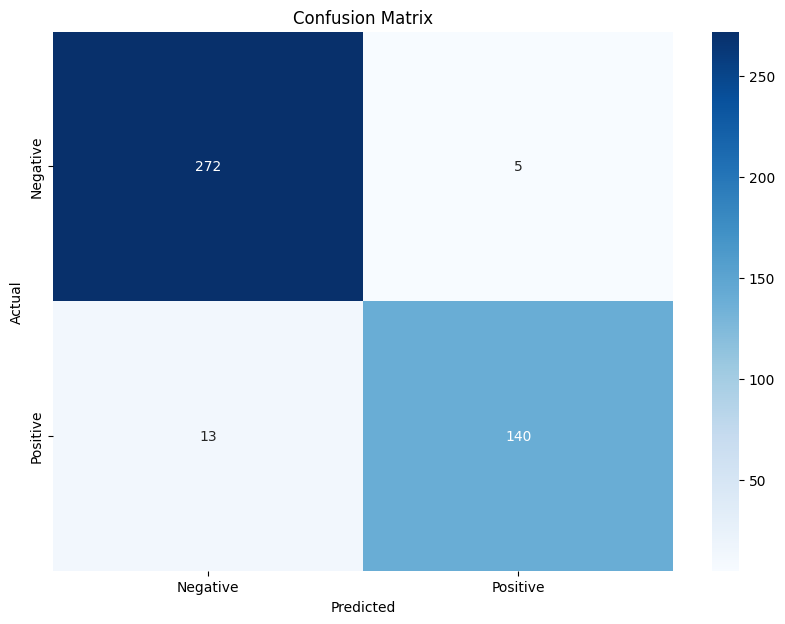

In [9]:
# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(x_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Mostrar los mejores hiperparámetros
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 500, 'selector__k': 10}


In [11]:
# Mostrar las características seleccionadas
selected_features = x.columns[best_model.named_steps['selector'].get_support()]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['EducationLevel', 'SleepQuality', 'SystolicBP', 'DiastolicBP',
       'CholesterolHDL', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints',
       'BehavioralProblems', 'ADL'],
      dtype='object')


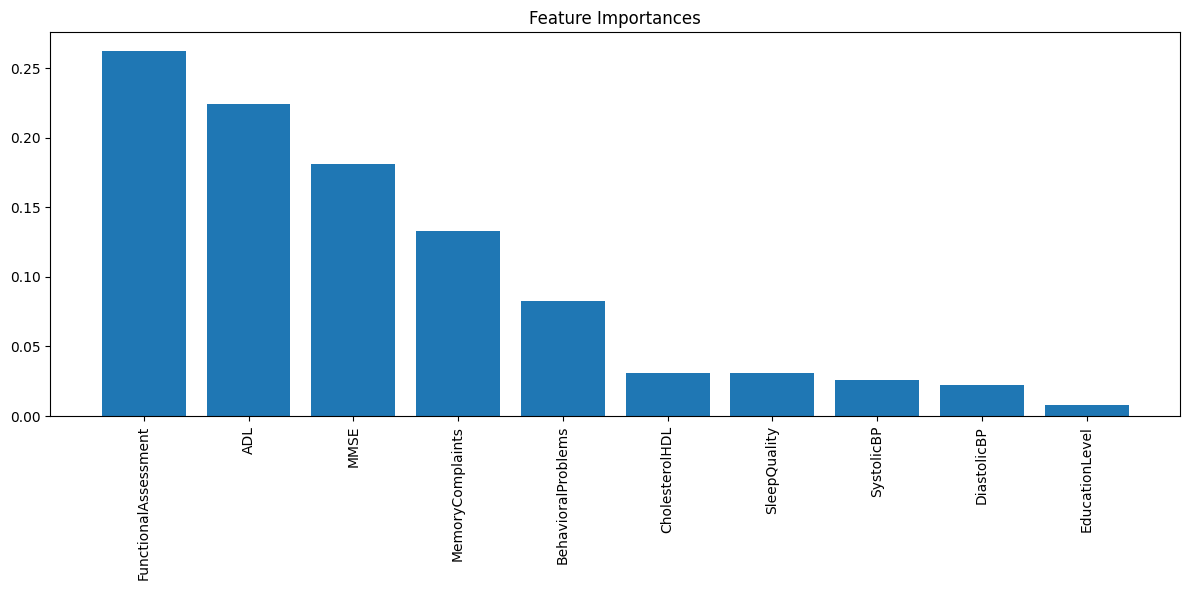

In [12]:
# Mostrar la importancia de las variables
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), selected_features[indices], rotation=90)
plt.tight_layout()
plt.show()

### 🎯 Importancia de las Características

**¿Por qué es crucial en medicina?**

La **interpretabilidad** es fundamental en aplicaciones médicas porque:

#### 🔍 **Importancia de Variables nos permite**:
- **Identificar biomarcadores clave** para el diagnóstico
- **Validar conocimiento médico** existente
- **Descubrir nuevos factores** de riesgo
- **Explicar decisiones** del modelo a médicos y pacientes
- **Generar hipótesis** para investigación futura

#### 📊 **Interpretación del Gráfico**:
- **Barras más altas**: Variables más importantes para la predicción
- **Orden descendente**: Ranking de relevancia predictiva
- **Valores normalizados**: La suma de todas las importancias = 1.0

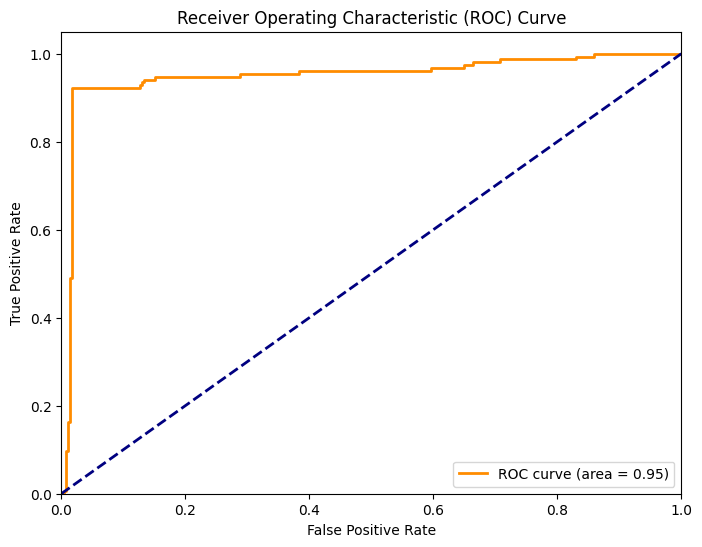

In [13]:
from sklearn.metrics import roc_curve, auc

# Mostrar la curva ROC
y_pred_proba = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Realizar validación cruzada
cv_scores = cross_val_score(best_model, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Accuracy Scores: [0.99069767 0.98372093 0.98372093 0.99534884 0.81585082]
Mean Cross-Validation Accuracy: 0.95


## 🎯 Conclusiones del Modelo de Machine Learning

### 🏆 Logros Principales:

#### ✅ **Modelo Desarrollado**:
- **Algoritmo**: Random Forest optimizado con selección automática de características
- **Pipeline robusto**: Incluye preprocesamiento y validación
- **Hiperparámetros optimizados**: Mediante búsqueda exhaustiva con validación cruzada
